Loading and preparing data...
Running initial t-SNE to find natural anomalies...


/Users/chenqinqin/opt/anaconda3/envs/ssenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Removed 6 anomalies. New dataset size: 994
Running t-SNE on pre-cleaned data...


/Users/chenqinqin/opt/anaconda3/envs/ssenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running t-SNE on feature-randomized data...


/Users/chenqinqin/opt/anaconda3/envs/ssenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Generating final visualization...


/var/folders/l5/ssrrw2995d53nqh7yfw61v200000gn/T/ipykernel_46408/864388565.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.88])


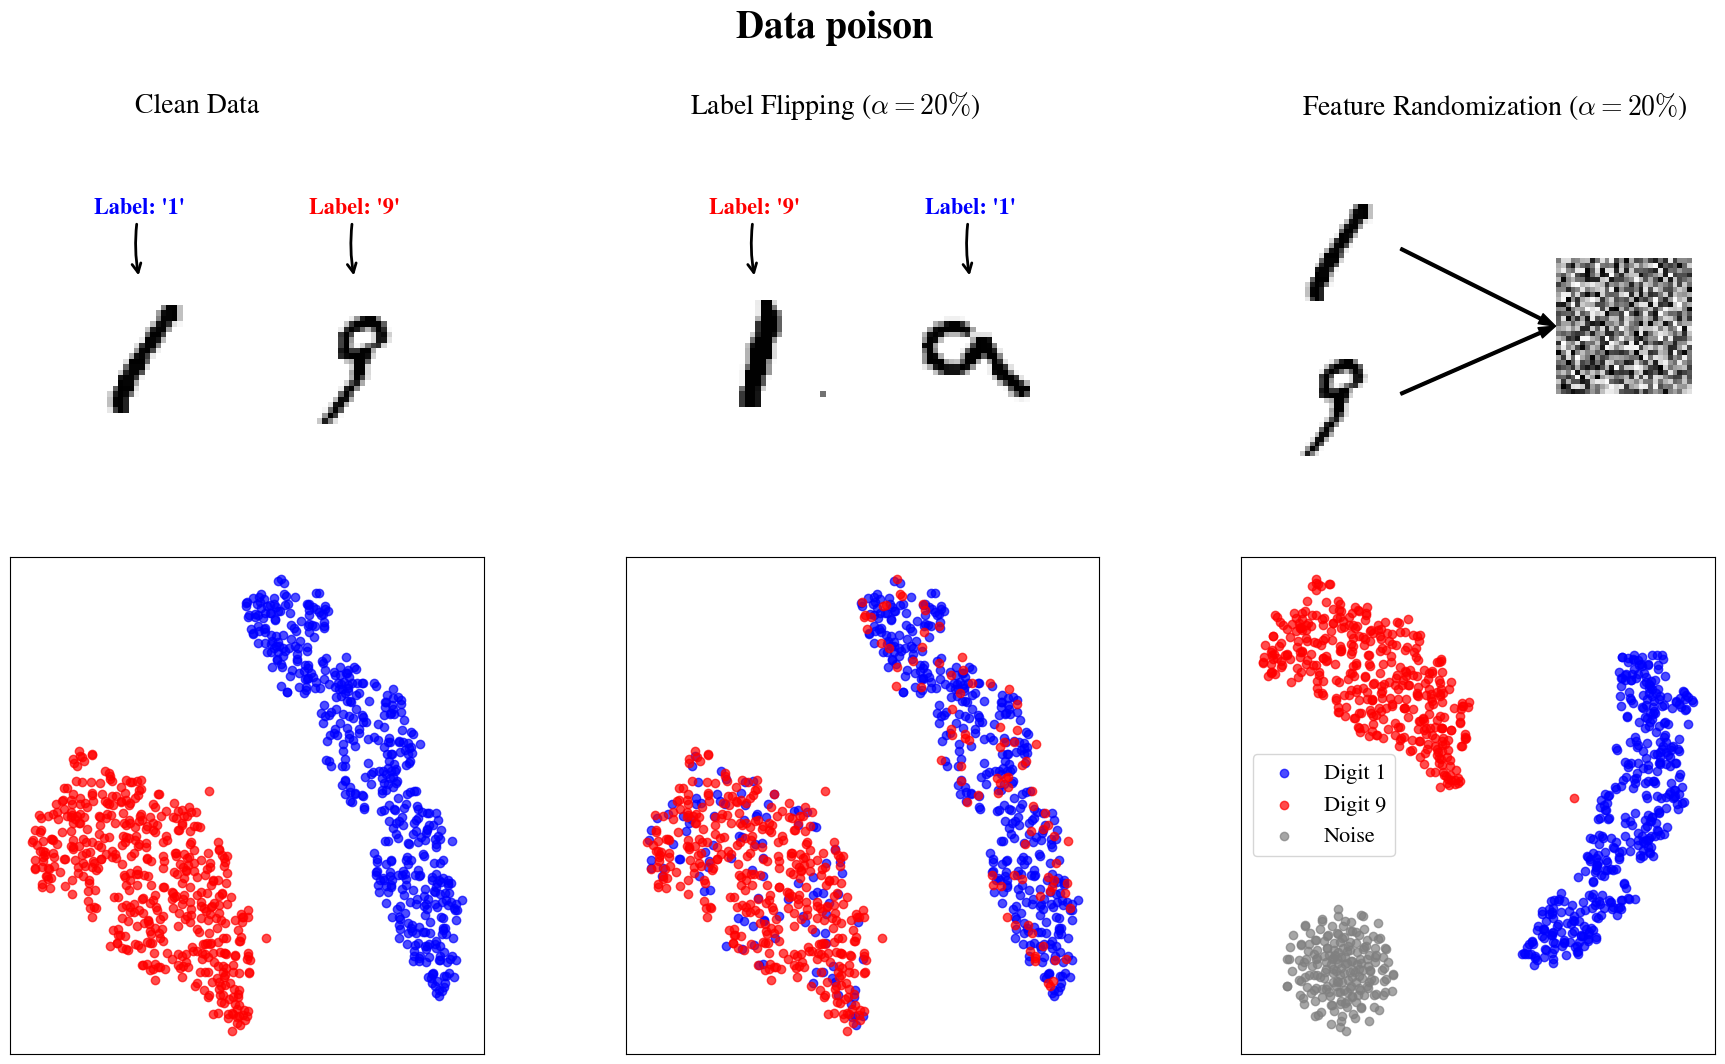

Done.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

# 设置字体以正确显示数学符号和通用字体
plt.rcParams['mathtext.fontset']='cm'
plt.rcParams['font.family']='STIXGeneral'

print("Loading and preparing data...")

# --- 1. 数据加载与预处理 ---
def load_and_prepare_data(n_samples_per_class=500):
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')
    X = mnist.data.astype('float32')
    y = mnist.target.astype('int64')

    mask = (y == 1) | (y == 9)
    X_filtered, y_filtered = X[mask], y[mask]

    X_1 = X_filtered[y_filtered == 1][:n_samples_per_class]
    y_1 = y_filtered[y_filtered == 1][:n_samples_per_class]
    X_9 = X_filtered[y_filtered == 9][:n_samples_per_class]
    y_9 = y_filtered[y_filtered == 9][:n_samples_per_class]

    X_clean = np.vstack([X_1, X_9])
    y_clean = np.hstack([y_1, y_9])

    X_clean_normalized = normalize(X_clean, norm='l2', axis=1)
    return X_clean_normalized, y_clean

# --- 2. 异常点识别与移除 ---
def find_and_remove_anomalies(X, y):
    print("Running initial t-SNE to find natural anomalies...")
    tsne_temp = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    X_tsne_temp = tsne_temp.fit_transform(X)

    centroid_1 = X_tsne_temp[y == 1].mean(axis=0)
    centroid_9 = X_tsne_temp[y == 9].mean(axis=0)
    
    dist_to_1 = cdist(X_tsne_temp, [centroid_1])
    dist_to_9 = cdist(X_tsne_temp, [centroid_9])

    is_anomaly = ((y == 1) & (dist_to_1 > dist_to_9).flatten()) | \
                 ((y == 9) & (dist_to_9 > dist_to_1).flatten())
    
    anomalous_indices = np.where(is_anomaly)[0]
    
    X_filtered = np.delete(X, anomalous_indices, axis=0)
    y_filtered = np.delete(y, anomalous_indices, axis=0)
    
    print(f"Removed {len(anomalous_indices)} anomalies. New dataset size: {len(y_filtered)}")
    return X_filtered, y_filtered

# --- 3. 数据污染函数 ---
def flip_labels(y_true, flip_fraction=0.2):
    y_flipped = np.copy(y_true)
    n_samples = len(y_true)
    n_to_flip = int(n_samples * flip_fraction)
    flip_indices = np.random.choice(np.arange(n_samples), size=n_to_flip, replace=False)
    y_flipped[flip_indices] = 9 - y_flipped[flip_indices] + 1
    return y_flipped, flip_indices

def randomize_features(X_true, y_true, randomize_fraction=0.2):
    X_randomized, y_randomized = np.copy(X_true), np.copy(y_true)
    n_samples, n_features = X_true.shape
    n_to_randomize = int(n_samples * randomize_fraction)
    randomize_indices = np.random.choice(np.arange(n_samples), size=n_to_randomize, replace=False)
    random_noise = normalize(np.random.rand(n_to_randomize, n_features), norm='l2', axis=1)
    X_randomized[randomize_indices] = random_noise
    y_randomized[randomize_indices] = -1
    return X_randomized, y_randomized, randomize_indices

# --- 4. 主脚本与t-SNE计算 ---
X_orig, y_orig = load_and_prepare_data(n_samples_per_class=500)
X_clean, y_clean = find_and_remove_anomalies(X_orig, y_orig)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
print("Running t-SNE on pre-cleaned data...")
X_tsne_clean = tsne.fit_transform(X_clean)

y_flipped, flipped_indices = flip_labels(y_clean, flip_fraction=0.2)
X_randomized, y_randomized, randomized_indices = randomize_features(X_clean, y_clean, randomize_fraction=0.2)
print("Running t-SNE on feature-randomized data...")
X_tsne_randomized = tsne.fit_transform(X_randomized)

# --- 5. 绘图 ---
print("Generating final visualization...")
fig = plt.figure(figsize=(22, 12))
# **修改1: 添加主标题**
fig.suptitle("Data poison", fontsize=28, weight='bold')
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1.3], wspace=0.3, hspace=0.1)
colors = {1: 'blue', 9: 'red', -1: 'grey'}
label_map = {1: "'1'", 9: "'9'"}
arrow_props = dict(facecolor='black', arrowstyle='->', connectionstyle="arc3,rad=0.1", lw=2)

# --- 第一列: Clean Data ---
# **修改2: 使用箭头指向标签**
ax1_top = fig.add_subplot(gs[0, 0])
idx_1 = np.where(y_clean == 1)[0][0]
idx_9 = np.where(y_clean == 9)[0][1] # 使用不同的索引以防重叠
ax1_top.imshow(X_clean[idx_1].reshape(28, 28), cmap='gray_r', extent=[0, 28, 0, 28])
ax1_top.imshow(X_clean[idx_9].reshape(28, 28), cmap='gray_r', extent=[40, 68, 0, 28])
ax1_top.annotate(f"Label: {label_map[1]}", xy=(14, 28), xytext=(14, 40), ha='center',
                 color=colors[1], fontsize=16, weight='bold', arrowprops=arrow_props)
ax1_top.annotate(f"Label: {label_map[9]}", xy=(54, 28), xytext=(54, 40), ha='center',
                 color=colors[9], fontsize=16, weight='bold', arrowprops=arrow_props)
ax1_top.set_xlim(-10, 78)
ax1_top.set_ylim(-5, 45)
ax1_top.axis('off')

ax1_bottom = fig.add_subplot(gs[1, 0])
for label_val, color in colors.items():
    if label_val in y_clean:
        mask = y_clean == label_val
        ax1_bottom.scatter(X_tsne_clean[mask, 0], X_tsne_clean[mask, 1], c=color, alpha=0.7)
ax1_bottom.set_xticks([]); ax1_bottom.set_yticks([])

# --- 第二列: Label Flipping ---
# **修改3: 显示两种翻转情况并使用箭头**
ax2_top = fig.add_subplot(gs[0, 1])
flipped_1_idx = next(i for i in flipped_indices if y_clean[i] == 1)
flipped_9_idx = next(i for i in flipped_indices if y_clean[i] == 9)
ax2_top.imshow(X_clean[flipped_1_idx].reshape(28, 28), cmap='gray_r', extent=[0, 28, 0, 28])
ax2_top.imshow(X_clean[flipped_9_idx].reshape(28, 28), cmap='gray_r', extent=[40, 68, 0, 28])
ax2_top.annotate(f"Label: {label_map[9]}", xy=(14, 28), xytext=(14, 40), ha='center',
                 color=colors[9], fontsize=16, weight='bold', arrowprops=arrow_props)
ax2_top.annotate(f"Label: {label_map[1]}", xy=(54, 28), xytext=(54, 40), ha='center',
                 color=colors[1], fontsize=16, weight='bold', arrowprops=arrow_props)
ax2_top.set_xlim(-10, 78)
ax2_top.set_ylim(-5, 45)
ax2_top.axis('off')

ax2_bottom = fig.add_subplot(gs[1, 1])
for label_val, color in colors.items():
    if label_val in y_flipped:
        mask = y_flipped == label_val
        ax2_bottom.scatter(X_tsne_clean[mask, 0], X_tsne_clean[mask, 1], c=color, alpha=0.7)
ax2_bottom.set_xticks([]); ax2_bottom.set_yticks([])

# --- 第三列: Feature Randomization ---
# **修改4: 1和9都指向噪声图**
ax3_top = fig.add_subplot(gs[0, 2])
idx_orig_1 = np.where((y_clean == 1) & (~np.isin(np.arange(len(y_clean)), randomized_indices)))[0][0]
idx_orig_9 = np.where((y_clean == 9) & (~np.isin(np.arange(len(y_clean)), randomized_indices)))[0][0]
idx_noise = randomized_indices[0]
# 左侧显示原始 1 和 9
ax3_top.imshow(X_clean[idx_orig_1].reshape(28, 28), cmap='gray_r', extent=[0, 28, 30, 58])
ax3_top.imshow(X_clean[idx_orig_9].reshape(28, 28), cmap='gray_r', extent=[0, 28, 0, 28])
# 右侧显示噪声图
ax3_top.imshow(X_randomized[idx_noise].reshape(28, 28), cmap='gray', extent=[60, 88, 14, 42])
# 从 1 指向噪声
ax3_top.annotate("", xy=(60, 28), xytext=(28, 44), arrowprops=dict(facecolor='black', shrinkA=5, shrinkB=5, width=2, headwidth=8))
# 从 9 指向噪声
ax3_top.annotate("", xy=(60, 28), xytext=(28, 14), arrowprops=dict(facecolor='black', shrinkA=5, shrinkB=5, width=2, headwidth=8))
ax3_top.set_xlim(-5, 93)
ax3_top.set_ylim(-5, 63)
ax3_top.axis('off')

ax3_bottom = fig.add_subplot(gs[1, 2])
for label_val, color in colors.items():
    if label_val in y_randomized:
        mask = y_randomized == label_val
        label_text = f"Digit {label_val}" if label_val != -1 else "Noise"
        ax3_bottom.scatter(X_tsne_randomized[mask, 0], X_tsne_randomized[mask, 1], c=color, label=label_text, alpha=0.7)
ax3_bottom.set_xticks([]); ax3_bottom.set_yticks([])
ax3_bottom.legend(loc='best', fontsize=16)

# --- 添加列标题 ---
fig.text(0.21, 0.9, r'Clean Data', ha='center', va='center', fontsize=20)
fig.text(0.5,  0.9, r'Label Flipping ($\alpha=20\%$)', ha='center', va='center', fontsize=20)
fig.text(0.8, 0.9, r'Feature Randomization ($\alpha=20\%$)', ha='center', va='center', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.savefig('data_poison_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()
print("Done.")

In [10]:
plt.rcParams['mathtext.fontset']='cm'
plt.rcParams['font.family']='STIXGeneral'

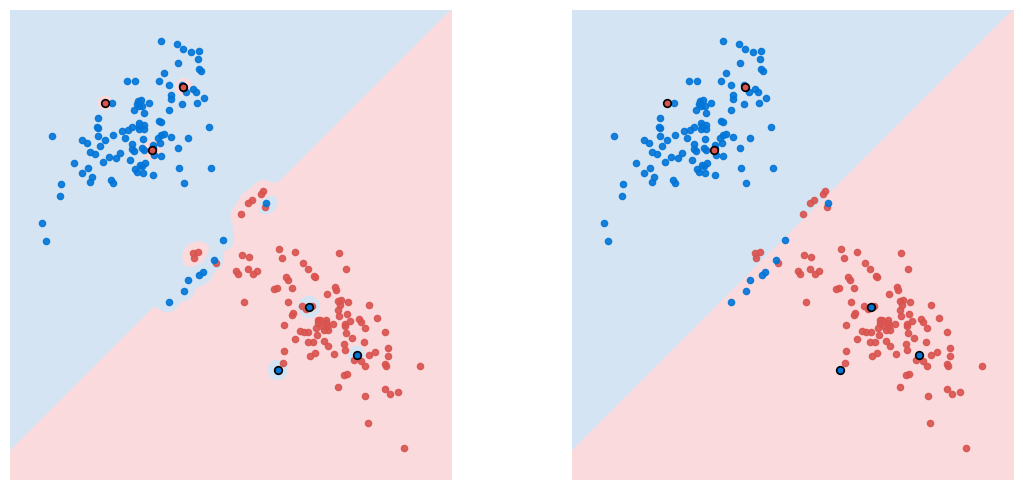

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# --- 1. Generate Consistent Data for Both Plots ---

# Set a random seed for reproducibility
np.random.seed(43)

# --- Main Clusters ---
# Generate Class 0 (red) data points in the bottom-right
mean0 = [3, -3]
cov0 = [[1.5, -0.8], [-0.8, 1.5]]
X0 = np.random.multivariate_normal(mean0, cov0, 100)

# Generate Class 1 (blue) data points in the top-left
mean1 = [-3, 3]
cov1 = [[1.5, 0.8], [0.8, 1.5]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# --- Deep Outliers (to create "islands") ---
# Blue outliers (Class 1) in red territory
blue_outliers = np.array([
    [2.5, -2.5],
    [4.0, -4.0],
    [1.5, -4.5]
])
# Red outliers (Class 0) in blue territory
red_outliers = np.array([
    [-2.5, 2.5],
    [-4.0, 4.0],
    [-1.5, 4.5]
])

# --- Boundary Noise (to create a "rugged" boundary) ---
# Create mislabeled points very close to the true y=x decision boundary
num_boundary_noise = 8
# Red points (Class 0) just on the blue side of the boundary
boundary_noise_red_x = np.random.uniform(-2, 2, num_boundary_noise)
boundary_noise_red_y = boundary_noise_red_x + np.random.uniform(0.1, 0.5, num_boundary_noise)
boundary_noise_red = np.c_[boundary_noise_red_x, boundary_noise_red_y]

# Blue points (Class 1) just on the red side of the boundary
boundary_noise_blue_x = np.random.uniform(-2, 2, num_boundary_noise)
boundary_noise_blue_y = boundary_noise_blue_x - np.random.uniform(0.1, 0.5, num_boundary_noise)
boundary_noise_blue = np.c_[boundary_noise_blue_x, boundary_noise_blue_y]

# Combine all data points
X = np.vstack([
    X0, X1,
    blue_outliers, red_outliers,
    boundary_noise_red, boundary_noise_blue
])

# Define colors
color_red = '#d9534f'
color_blue = '#0275d8'
light_red = '#fADADD'
light_blue = '#D5E4F2'
custom_cmap = ListedColormap([light_red, light_blue])


# --- 2. Create the Figure and Axes ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.set_facecolor('white')


# --- 3. Define Decision Boundaries ---
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# a) Robust Generalization: A simple, smooth line (y - x = 0)
z_robust = grid_points[:, 1] - grid_points[:, 0]
Z_robust = z_robust.reshape(xx.shape)

# b) Brittle Memorization: Start with robust and add contortions for ALL mislabeled points
z_brittle = np.copy(z_robust)

# Add contortions for DEEP outliers (creating islands)
for point in blue_outliers:
    dist_sq = np.sum((grid_points - point)**2, axis=1)
    z_brittle += 15 * np.exp(-dist_sq / 0.1) # Positive bump for blue
for point in red_outliers:
    dist_sq = np.sum((grid_points - point)**2, axis=1)
    z_brittle -= 15 * np.exp(-dist_sq / 0.1) # Negative bump for red

# Add contortions for BOUNDARY noise (creating a rugged line)
for point in boundary_noise_blue:
    dist_sq = np.sum((grid_points - point)**2, axis=1)
    z_brittle += 5 * np.exp(-dist_sq / 0.05) # Positive bump for blue
for point in boundary_noise_red:
    dist_sq = np.sum((grid_points - point)**2, axis=1)
    z_brittle -= 5 * np.exp(-dist_sq / 0.05) # Negative bump for red

Z_brittle = z_brittle.reshape(xx.shape)


# --- 4. Plotting ---
plot_titles = ["Brittle Memorization", "Robust Generalization"]
axes = [ax1, ax2]
decision_functions = [Z_brittle, Z_robust]

for i, ax in enumerate(axes):
    # Plot the decision regions
    ax.contourf(xx, yy, decision_functions[i] > 0, cmap=custom_cmap, levels=1)

    # Plot the main data clusters
    ax.scatter(X0[:, 0], X0[:, 1], c=color_red, s=20, alpha=0.9)
    ax.scatter(X1[:, 0], X1[:, 1], c=color_blue, s=20, alpha=0.9)

    # Plot the boundary noise points
    ax.scatter(boundary_noise_red[:, 0], boundary_noise_red[:, 1], c=color_red, s=20, alpha=0.9)
    ax.scatter(boundary_noise_blue[:, 0], boundary_noise_blue[:, 1], c=color_blue, s=20, alpha=0.9)

    # Plot the deep outliers on top with a distinct border
    ax.scatter(blue_outliers[:, 0], blue_outliers[:, 1], c=color_blue, s=30,
               edgecolor='black', linewidth=1.2, zorder=3)
    ax.scatter(red_outliers[:, 0], red_outliers[:, 1], c=color_red, s=30,
               edgecolor='black', linewidth=1.2, zorder=3)

    # --- 5. Styling ---
    # ax.text(0.75, 1.05, plot_titles[i],
    #         transform=ax.transAxes, fontsize=28, fontweight='bold',
    #         verticalalignment='top', horizontalalignment='right')
    
    # Clean up axes for diagrammatic style
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect('equal', adjustable='box')


# Final adjustments and display
plt.tight_layout()
# plt.subplots_adjust(hspace=0.0001)

plt.show()

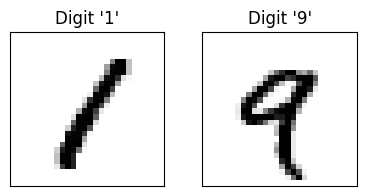


===== BASELINE: TRAINING ON CLEAN DATA (for all seeds) =====

--- Running Clean Data with Seed: 0 ---
Clean MLP (Seed 0) - Train Acc: 0.5000, Val Acc: 0.5000
Clean MLP (Seed 0) - Sum of Eigenvalues: 0.2500
Clean QNN (Seed 0) - Train Acc: 0.9886, Val Acc: 0.9800
Clean QNN (Seed 0) - Sum of Eigenvalues: 7.0040

--- Running Clean Data with Seed: 42 ---
Clean MLP (Seed 42) - Train Acc: 0.5000, Val Acc: 0.5000
Clean MLP (Seed 42) - Sum of Eigenvalues: 0.2500
Clean QNN (Seed 42) - Train Acc: 0.9829, Val Acc: 0.9933
Clean QNN (Seed 42) - Sum of Eigenvalues: 6.4937

--- Running Clean Data with Seed: 123 ---
Clean MLP (Seed 123) - Train Acc: 1.0000, Val Acc: 0.9933
Clean MLP (Seed 123) - Sum of Eigenvalues: 0.1367
Clean QNN (Seed 123) - Train Acc: 0.9886, Val Acc: 0.9867
Clean QNN (Seed 123) - Sum of Eigenvalues: 6.0294

--- Running Clean Data with Seed: 1024 ---
Clean MLP (Seed 1024) - Train Acc: 0.9971, Val Acc: 1.0000
Clean MLP (Seed 1024) - Sum of Eigenvalues: 0.0923
Clean QNN (Seed 1024) 

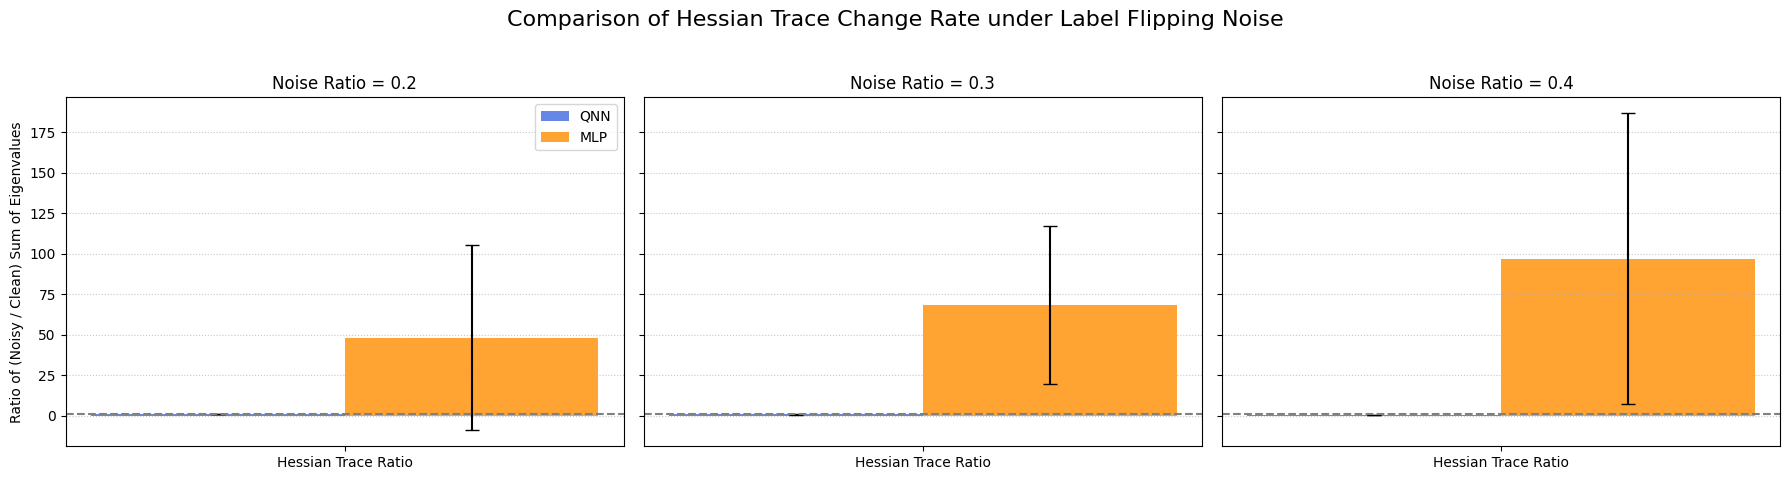

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorcircuit as tc
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import time
import random

# ====================== 1. 全局配置 (GLOBAL CONFIGURATION) ======================
N_SAMPLES_PER_CLASS = 250
IMAGE_DIM = 28 * 28
PADDED_DIM = 1024
N_QUBITS = 10 
MLP_LAYERS = [8, 2]
QNN_DEPTH = 5
EPOCHS = 50 
BATCH_SIZE = 32
LEARNING_RATE = 0.01

HESSIAN_SAMPLES = 100 
NOISE_RATIOS = [0.2, 0.3, 0.4]
SEEDS = [0, 42, 123, 1024, 2048]

K = tc.set_backend("jax")
tc.set_dtype("complex128")
eps = 1e-14

# ====================== 辅助函数: 设置种子 ======================
def set_seeds(seed_value):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

# ====================== 2. 数据加载与处理 (DATA LOADING & PREPROCESSING) ======================
def load_and_preprocess_mnist():
    (x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
    mask_ones = (y_train == 1); mask_nines = (y_train == 9)
    x_ones = x_train[mask_ones][:N_SAMPLES_PER_CLASS]
    x_nines = x_train[mask_nines][:N_SAMPLES_PER_CLASS]
    images = np.concatenate((x_ones, x_nines), axis=0)
    labels_raw = np.concatenate((np.zeros(len(x_ones)), np.ones(len(x_nines))), axis=0)
    images_flat = images.reshape(images.shape[0], -1) / 255.0
    images_padded = np.pad(images_flat, ((0, 0), (0, PADDED_DIM - IMAGE_DIM)), 'constant')
    norms = np.linalg.norm(images_padded, axis=1, keepdims=True)
    images_normalized = images_padded / (norms + eps)
    return images_normalized, labels_raw

def create_noisy_labels(y_train, noise_ratio):
    n_flip = int(len(y_train) * noise_ratio)
    flip_indices = np.random.choice(len(y_train), n_flip, replace=False)
    y_train_noisy = np.copy(y_train)
    y_train_noisy[flip_indices] = 1 - y_train_noisy[flip_indices]
    return y_train_noisy

# ====================== 3. 模型定义 (MODEL DEFINITIONS) - [核心修改] ======================
def build_ansatz(params, inputs):
    c = tc.Circuit(N_QUBITS, inputs=inputs)
    for j in range(QNN_DEPTH):
        for i in range(N_QUBITS): c.rx(i, theta=params[j, i, 0])
        for i in range(N_QUBITS): c.ry(i, theta=params[j, i, 1])
        for i in range(N_QUBITS): c.cnot(i, (i + 1) % N_QUBITS)
    return c

y_pred_qnn_vmap = K.jit(K.vmap(lambda p, x: K.sigmoid(K.real(build_ansatz(p, x).expectation_ps(z=[N_QUBITS - 1])) * 5), vectorized_argnums=1))

def loss_qnn(params, xt, yt):
    yp = y_pred_qnn_vmap(params, xt)
    return -K.mean(yt * K.log(yp + eps) + (1 - yt) * K.log(1 - yp + eps))

class QNN:
    def __init__(self):
        self.params = K.convert_to_tensor(np.random.normal(scale=0.01, size=(QNN_DEPTH, N_QUBITS, 2)))
        self.vgf = K.jit(K.value_and_grad(loss_qnn, argnums=0))
    def fit(self, xs_train, ys_train):
        dataset = tf.data.Dataset.from_tensor_slices((xs_train, ys_train)).repeat(EPOCHS).shuffle(2000).batch(BATCH_SIZE)
        optimizer = optax.adam(learning_rate=LEARNING_RATE)
        opt_state = optimizer.init(self.params)
        for x_batch, y_batch in dataset:
            _, gs = self.vgf(self.params, x_batch.numpy(), y_batch.numpy())
            updates, opt_state = optimizer.update(gs, opt_state)
            self.params = optax.apply_updates(self.params, updates)
    def get_params(self): return self.params
    
    # --- 新增: QNN的评估函数 ---
    def evaluate(self, xs, ys):
        """计算QNN在给定数据集上的准确率"""
        # 预测概率
        y_pred_proba = y_pred_qnn_vmap(self.params, xs)
        # 将概率转换为类别 (0 或 1)
        y_pred = (np.array(y_pred_proba) > 0.5).astype(int)
        # 使用 sklearn 的 accuracy_score 计算准确率
        return accuracy_score(ys, y_pred)

class KerasMLP:
    def __init__(self): self.model = self._build_model()
    def _build_model(self):
        model = Sequential([
            tf.keras.layers.Input(shape=(PADDED_DIM,)),
            Dense(MLP_LAYERS[0], activation="relu"),
            Dense(MLP_LAYERS[1], activation="relu"),
            Dense(1, activation="sigmoid")
        ])
        # [修改] 增加 'accuracy' 指标，方便直接评估
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="binary_crossentropy", metrics=['accuracy'])
        return model
    def fit(self, xs_train, ys_train):
        self.model.fit(xs_train, ys_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    
    # --- 新增: KerasMLP的评估函数 (更通用) ---
    def evaluate(self, xs, ys):
        """计算Keras MLP在给定数据集上的准确率"""
        loss, accuracy = self.model.evaluate(xs, ys, verbose=0)
        return accuracy

# ====================== 4. Hessian分析函数 (HESSIAN ANALYSIS FUNCTIONS) ======================
def get_qnn_hessian(qnn_model, data_x, data_y):
    original_params = qnn_model.get_params()
    params_real_flat = jnp.concatenate([p.real.flatten() for p in jax.tree_util.tree_leaves(original_params)])
    params_imag_flat = jnp.concatenate([p.imag.flatten() for p in jax.tree_util.tree_leaves(original_params)])
    real_valued_params_vec = jnp.concatenate([params_real_flat, params_imag_flat])
    def real_input_loss_qnn(real_params, x, y):
        num_real_params = params_real_flat.shape[0]
        real_parts_flat = real_params[:num_real_params]
        imag_parts_flat = real_params[num_real_params:]
        current_idx_real, current_idx_imag = 0, 0
        reconstructed_params_leaves = []
        _, treedef = jax.tree_util.tree_flatten(original_params)
        for param_template in jax.tree_util.tree_leaves(original_params):
            shape, size = param_template.shape, param_template.size
            real_part = real_parts_flat[current_idx_real : current_idx_real + size].reshape(shape)
            imag_part = imag_parts_flat[current_idx_imag : current_idx_imag + size].reshape(shape)
            current_idx_real += size; current_idx_imag += size
            reconstructed_params_leaves.append(real_part + 1j * imag_part)
        reconstructed_params = jax.tree_util.tree_unflatten(treedef, reconstructed_params_leaves)
        return loss_qnn(reconstructed_params, x, y)
    hessian_matrix = jax.hessian(real_input_loss_qnn)(real_valued_params_vec, data_x, data_y)
    return hessian_matrix

def get_mlp_hessian(model, data_x, data_y):
    trainable_vars = model.trainable_variables
    flat_params = tf.concat([tf.reshape(v, [-1]) for v in trainable_vars], axis=0)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(flat_params)
        current_idx = 0; updated_vars = []
        for var in trainable_vars:
            updated_vars.append(tf.reshape(flat_params[current_idx : current_idx + tf.size(var)], var.shape))
            current_idx += tf.size(var)
        x = data_x
        for i in range(len(model.layers)):
            W, b = updated_vars[2*i], updated_vars[2*i+1]
            x = x @ W + b
            if i < len(model.layers) - 1: x = tf.nn.relu(x)
        y_pred = tf.nn.sigmoid(x)
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true=data_y, y_pred=y_pred))
        g = tape.gradient(loss, flat_params)
    hessian_matrix = tape.jacobian(g, flat_params)
    del tape
    return hessian_matrix.numpy() if hessian_matrix is not None else None

def get_sum_of_eigenvalues(hessian_matrix, model_name=""):
    if hessian_matrix is None or hessian_matrix.size == 0 or np.isnan(hessian_matrix).any():
        print(f"Warning: {model_name} Hessian is empty or contains NaNs. Returning NaN.")
        return np.nan
    eigenvalues = np.linalg.eigvalsh(hessian_matrix)
    return np.sum(eigenvalues)

# ====================== 5. 主实验循环 (MAIN EXPERIMENT LOOP) ======================
if __name__ == "__main__":
    X_full, y_full = load_and_preprocess_mnist()
    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
    idx_1 = np.where(y_full == 0)[0][0]
    axes[0].imshow(X_full[idx_1][:IMAGE_DIM].reshape(28, 28), cmap='gray_r')
    axes[0].set_title("Digit '1'"); axes[0].set_xticks([]); axes[0].set_yticks([])
    idx_9 = np.where(y_full == 1)[0][0]
    axes[1].imshow(X_full[idx_9][:IMAGE_DIM].reshape(28, 28), cmap='gray_r')
    axes[1].set_title("Digit '9'"); axes[1].set_xticks([]); axes[1].set_yticks([])
    plt.tight_layout(); plt.show()

    # --- [修改] 初始化结果存储字典，增加准确率条目 ---
    results = {
        ratio: {
            "qnn": {"trace": [], "train_acc": [], "val_acc": []}, 
            "mlp": {"trace": [], "train_acc": [], "val_acc": []}
        } for ratio in NOISE_RATIOS
    }
    results_clean = {
        "qnn": {"trace": [], "train_acc": [], "val_acc": []}, 
        "mlp": {"trace": [], "train_acc": [], "val_acc": []}
    }

    print("\n===== BASELINE: TRAINING ON CLEAN DATA (for all seeds) =====")
    for seed in SEEDS:
        print(f"\n--- Running Clean Data with Seed: {seed} ---")
        set_seeds(seed)
        X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, stratify=y_full)
        hessian_indices = np.random.choice(len(X_test), HESSIAN_SAMPLES, replace=False)
        X_hess, y_hess = X_test[hessian_indices], y_test[hessian_indices]
        
        # MLP (Clean)
        mlp_clean = KerasMLP(); mlp_clean.fit(X_train, y_train)
        # --- [新增] 计算并打印MLP准确率 ---
        acc_mlp_train = mlp_clean.evaluate(X_train, y_train)
        acc_mlp_val = mlp_clean.evaluate(X_test, y_test)
        print(f"Clean MLP (Seed {seed}) - Train Acc: {acc_mlp_train:.4f}, Val Acc: {acc_mlp_val:.4f}")
        results_clean["mlp"]["train_acc"].append(acc_mlp_train)
        results_clean["mlp"]["val_acc"].append(acc_mlp_val)
        
        hessian_mlp = get_mlp_hessian(mlp_clean.model, tf.constant(X_hess, dtype=tf.float32), tf.constant(y_hess.reshape(-1, 1), dtype=tf.float32))
        sum_eig_mlp = get_sum_of_eigenvalues(hessian_mlp, "Clean MLP")
        results_clean["mlp"]["trace"].append(sum_eig_mlp)
        print(f"Clean MLP (Seed {seed}) - Sum of Eigenvalues: {sum_eig_mlp:.4f}")

        # QNN (Clean)
        qnn_clean = QNN(); qnn_clean.fit(X_train, y_train)
        # --- [新增] 计算并打印QNN准确率 ---
        acc_qnn_train = qnn_clean.evaluate(X_train, y_train)
        acc_qnn_val = qnn_clean.evaluate(X_test, y_test)
        print(f"Clean QNN (Seed {seed}) - Train Acc: {acc_qnn_train:.4f}, Val Acc: {acc_qnn_val:.4f}")
        results_clean["qnn"]["train_acc"].append(acc_qnn_train)
        results_clean["qnn"]["val_acc"].append(acc_qnn_val)

        hessian_qnn = get_qnn_hessian(qnn_clean, X_hess, y_hess)
        sum_eig_qnn = get_sum_of_eigenvalues(hessian_qnn, "Clean QNN")
        results_clean["qnn"]["trace"].append(sum_eig_qnn)
        print(f"Clean QNN (Seed {seed}) - Sum of Eigenvalues: {sum_eig_qnn:.4f}")

    for noise_ratio in NOISE_RATIOS:
        print(f"\n\n===== STARTING EXPERIMENTS FOR NOISE RATIO: {noise_ratio} =====")
        for seed in SEEDS:
            print(f"\n--- Running Noise Ratio {noise_ratio} with Seed: {seed} ---")
            set_seeds(seed)
            X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, stratify=y_full)
            y_train_noisy = create_noisy_labels(y_train, noise_ratio)
            hessian_indices = np.random.choice(len(X_test), HESSIAN_SAMPLES, replace=False)
            X_hess, y_hess = X_test[hessian_indices], y_test[hessian_indices]
            
            # MLP (Noisy)
            mlp_noisy = KerasMLP(); mlp_noisy.fit(X_train, y_train_noisy)
            # --- [新增] 计算并打印MLP准确率 ---
            acc_mlp_train_noisy = mlp_noisy.evaluate(X_train, y_train_noisy)
            acc_mlp_val_noisy = mlp_noisy.evaluate(X_test, y_test)
            print(f"Noisy MLP (R={noise_ratio},S={seed}) - Train Acc: {acc_mlp_train_noisy:.4f}, Val Acc: {acc_mlp_val_noisy:.4f}")
            results[noise_ratio]["mlp"]["train_acc"].append(acc_mlp_train_noisy)
            results[noise_ratio]["mlp"]["val_acc"].append(acc_mlp_val_noisy)
            
            hessian_mlp = get_mlp_hessian(mlp_noisy.model, tf.constant(X_hess, dtype=tf.float32), tf.constant(y_hess.reshape(-1, 1), dtype=tf.float32))
            sum_eig_mlp = get_sum_of_eigenvalues(hessian_mlp, f"Noisy MLP (R={noise_ratio},S={seed})")
            results[noise_ratio]["mlp"]["trace"].append(sum_eig_mlp)
            print(f"Noisy MLP (Ratio {noise_ratio}, Seed {seed}) - Sum of Eigenvalues: {sum_eig_mlp:.4f}")

            # QNN (Noisy)
            qnn_noisy = QNN(); qnn_noisy.fit(X_train, y_train_noisy)
            # --- [新增] 计算并打印QNN准确率 ---
            acc_qnn_train_noisy = qnn_noisy.evaluate(X_train, y_train_noisy)
            acc_qnn_val_noisy = qnn_noisy.evaluate(X_test, y_test)
            print(f"Noisy QNN (R={noise_ratio},S={seed}) - Train Acc: {acc_qnn_train_noisy:.4f}, Val Acc: {acc_qnn_val_noisy:.4f}")
            results[noise_ratio]["qnn"]["train_acc"].append(acc_qnn_train_noisy)
            results[noise_ratio]["qnn"]["val_acc"].append(acc_qnn_val_noisy)

            hessian_qnn = get_qnn_hessian(qnn_noisy, X_hess, y_hess)
            sum_eig_qnn = get_sum_of_eigenvalues(hessian_qnn, f"Noisy QNN (R={noise_ratio},S={seed})")
            results[noise_ratio]["qnn"]["trace"].append(sum_eig_qnn)
            print(f"Noisy QNN (Ratio {noise_ratio}, Seed {seed}) - Sum of Eigenvalues: {sum_eig_qnn:.4f}")

    # ====================== 6. 结果分析与绘图 (RESULTS ANALYSIS & PLOTTING) ======================
    print("\n\n===== FINAL ANALYSIS AND PLOTTING =====")
    
    base_qnn_mean = np.nanmean(results_clean["qnn"]["trace"])
    base_mlp_mean = np.nanmean(results_clean["mlp"]["trace"])
    print(f"Baseline QNN Sum of Eigenvalues (avg over seeds): {base_qnn_mean:.4f}")
    print(f"Baseline MLP Sum of Eigenvalues (avg over seeds): {base_mlp_mean:.4f}")

    ratios = {"qnn": {ratio: [] for ratio in NOISE_RATIOS}, "mlp": {ratio: [] for ratio in NOISE_RATIOS}}
    for ratio in NOISE_RATIOS:
        ratios["qnn"][ratio] = np.array(results[ratio]["qnn"]["trace"]) / base_qnn_mean
        ratios["mlp"][ratio] = np.array(results[ratio]["mlp"]["trace"]) / base_mlp_mean

    n_ratios = len(NOISE_RATIOS)
    fig, axes = plt.subplots(1, n_ratios, figsize=(6 * n_ratios, 5), sharey=True)
    if n_ratios == 1: axes = [axes]

    for i, ratio in enumerate(NOISE_RATIOS):
        ax = axes[i]
        qnn_data = ratios["qnn"][ratio]
        mlp_data = ratios["mlp"][ratio]
        qnn_mean, qnn_std = np.nanmean(qnn_data), np.nanstd(qnn_data)
        mlp_mean, mlp_std = np.nanmean(mlp_data), np.nanstd(mlp_data)
        bar_width = 0.35; index = np.arange(1)
        ax.bar(index, qnn_mean, bar_width, yerr=qnn_std, capsize=5, label='QNN', color='royalblue', alpha=0.8)
        ax.bar(index + bar_width, mlp_mean, bar_width, yerr=mlp_std, capsize=5, label='MLP', color='darkorange', alpha=0.8)
        ax.set_title(f'Noise Ratio = {ratio}')
        ax.set_xticks(index + bar_width / 2); ax.set_xticklabels(['Hessian Trace Ratio'])
        ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1.5)
        ax.grid(axis='y', linestyle=':', alpha=0.7)
    
    axes[0].set_ylabel('Ratio of (Noisy / Clean) Sum of Eigenvalues')
    axes[0].legend()
    plt.suptitle('Comparison of Hessian Trace Change Rate under Label Flipping Noise', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig("hessian_ratio_comparison.pdf", format='pdf', bbox_inches='tight')
    plt.show()

In [ ]:

np.save("clean.npy", results_clean, allow_pickle=True)
np.save("rito.npy", results, allow_pickle=True)

Loading saved results from .npy files...
Files loaded successfully.
Detected Noise Ratios: [0.2, 0.3, 0.4]

Filtering out trace values where |value - 0.25| < 0.01...
Data filtering complete.

Calculating ratios and aggregating data for combined plot...
Filtered Baseline QNN Sum of Eigenvalues (avg over seeds): 6.1928
Filtered Baseline MLP Sum of Eigenvalues (avg over seeds): 0.1939
Data aggregation complete.

Generating combined plot...

Combined plot saved as hessian_ratio_comparison_combined.pdf


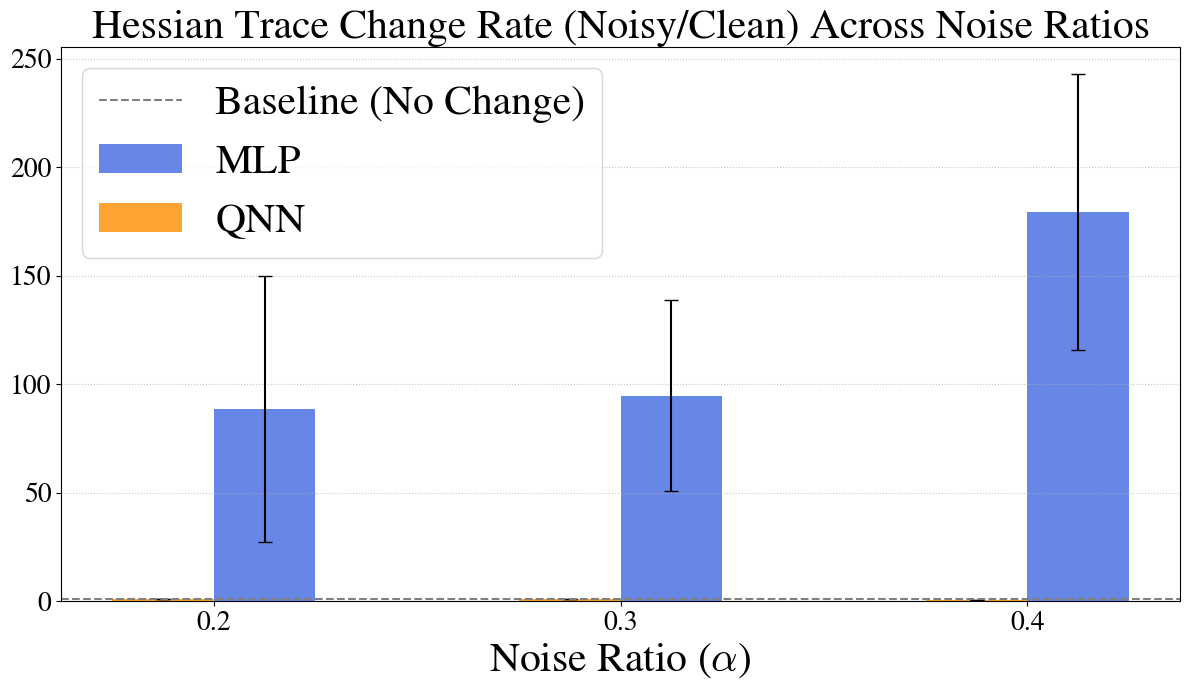

In [29]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset']='cm'
plt.rcParams['font.family']='STIXGeneral'

# ====================== 1. 加载已保存的实验结果 ======================
print("Loading saved results from .npy files...")
try:
    results_clean = np.load("clean.npy", allow_pickle=True).item()
    results = np.load("rito.npy", allow_pickle=True).item()
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Error: clean.npy or rito.npy not found.")
    print("Please make sure these files are in the same directory as the script.")
    exit()

# --- 提取实验参数 ---
NOISE_RATIOS = sorted(list(results.keys())) # 使用 sorted 保证顺序
print(f"Detected Noise Ratios: {NOISE_RATIOS}")

# ====================== 2. 数据过滤 ======================
THRESHOLD_VALUE = 0.25
TOLERANCE = 0.01  # |x - 0.25| < 0.01

def filter_data(data_dict):
    for key in data_dict:
        trace_list = data_dict[key].get("trace", [])
        if not trace_list: continue
        filtered_traces = [
            np.nan if val is not None and abs(val - THRESHOLD_VALUE) < TOLERANCE else val 
            for val in trace_list
        ]
        data_dict[key]["trace"] = filtered_traces
    return data_dict

print(f"\nFiltering out trace values where |value - {THRESHOLD_VALUE}| < {TOLERANCE}...")
results_clean = filter_data(results_clean)
for ratio in NOISE_RATIOS:
    results[ratio] = filter_data(results[ratio])
print("Data filtering complete.")

# ====================== 3. 结果分析与数据聚合 ======================
print("\nCalculating ratios and aggregating data for combined plot...")

base_qnn_mean = np.nanmean(results_clean["qnn"]["trace"])
base_mlp_mean = np.nanmean(results_clean["mlp"]["trace"])

print(f"Filtered Baseline QNN Sum of Eigenvalues (avg over seeds): {base_qnn_mean:.4f}")
print(f"Filtered Baseline MLP Sum of Eigenvalues (avg over seeds): {base_mlp_mean:.4f}")

# --- 为绘图准备数据列表 ---
qnn_means, qnn_stds = [], []
mlp_means, mlp_stds = [], []

for ratio in NOISE_RATIOS:
    # 计算 QNN 的均值和标准差
    qnn_ratios = np.array(results[ratio]["qnn"]["trace"]) / base_qnn_mean
    qnn_means.append(np.nanmean(qnn_ratios))
    qnn_stds.append(np.nanstd(qnn_ratios))

    # 计算 MLP 的均值和标准差
    mlp_ratios = np.array(results[ratio]["mlp"]["trace"]) / base_mlp_mean
    mlp_means.append(np.nanmean(mlp_ratios))
    mlp_stds.append(np.nanstd(mlp_ratios))

print("Data aggregation complete.")

# ====================== 4. 绘制合并后的分组条形图 ======================
print("\nGenerating combined plot...")

# --- 设置绘图参数 ---
x = np.arange(len(NOISE_RATIOS))  # X轴的位置 (0, 1, 2)
bar_width = 0.25  # 条形的宽度

fig, ax = plt.subplots(figsize=(12, 7)) # 创建一个单独的、更大的图形

# --- 绘制条形 ---
# 绘制 QNN 的条形，位置向左偏移半个条形宽度


# 绘制 MLP 的条形，位置向右偏移半个条形宽度
rects2 = ax.bar(x + bar_width/2, mlp_means, bar_width, yerr=mlp_stds, 
                label='MLP', color='royalblue', alpha=0.8, capsize=5)

rects1 = ax.bar(x - bar_width/2, qnn_means, bar_width, yerr=qnn_stds, 
                label='QNN', color='darkorange', alpha=0.8, capsize=5)

# --- 设置图形的标题、标签和刻度 ---
# ax.set_ylabel('Noisy / Clean', fontsize=20)
ax.set_xlabel('Noise Ratio ($\\alpha$)', fontsize=30)
ax.set_title('Hessian Trace Change Rate (Noisy/Clean) Across Noise Ratios', fontsize=30)

# 设置 X 轴的刻度位置和标签
ax.set_xticks(x)
ax.set_xticklabels(NOISE_RATIOS)
ax.tick_params(axis='both', which='major', labelsize=20)


# 设置 Y 轴范围和网格线
ax.set_ylim(bottom=0) # 确保 Y 轴从 0 开始
ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1.5, label='Baseline (No Change)')
ax.grid(axis='y', linestyle=':', alpha=0.7)

# 显示图例
ax.legend(fontsize=30)

# 自动调整布局
plt.tight_layout()

# --- 保存和显示 ---
output_filename = "hessian_ratio_comparison_combined.pdf"
fig.savefig(output_filename, format='pdf', bbox_inches='tight')
print(f"\nCombined plot saved as {output_filename}")

plt.show()


Generating combined plot with log scale...

Combined plot with log scale saved as hessian_ratio_comparison_log_scale.pdf


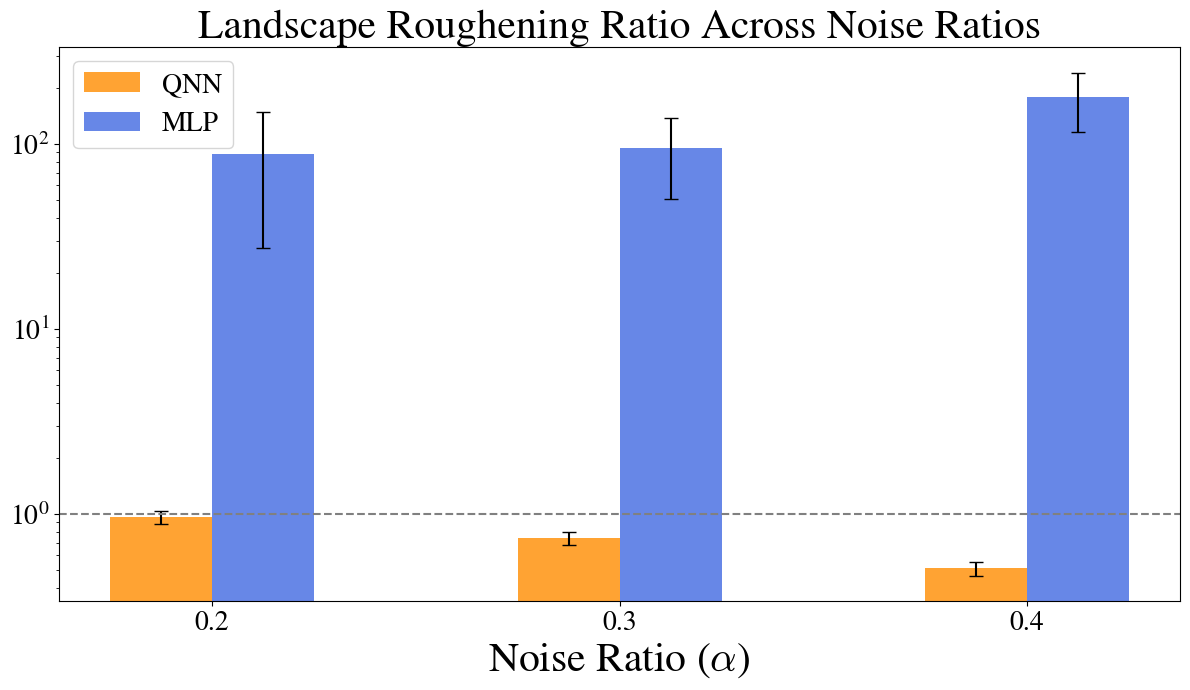

In [35]:
# ====================== 4. 绘制合并后的分组条形图 (使用对数坐标) ======================
print("\nGenerating combined plot with log scale...")

# --- 设置绘图参数 ---
x = np.arange(len(NOISE_RATIOS))
bar_width = 0.25 

fig, ax = plt.subplots(figsize=(12, 7))

# --- [核心修改] 数据预处理，为对数坐标做准备 ---
# 为了防止 log(0) 的错误，我们将所有0或负数替换为一个非常小的正数
# 这个小的“epsilon”值不会在图上被注意到，但能保证绘图不出错
log_epsilon = 1e-4

# 创建数据的安全副本以进行修改
qnn_means_log = np.maximum(qnn_means, log_epsilon)
mlp_means_log = np.maximum(mlp_means, log_epsilon)

# --- 绘制条形 ---
rects2 = ax.bar(x + bar_width/2, mlp_means_log, bar_width, yerr=mlp_stds, 
                label='MLP', color='royalblue', alpha=0.8, capsize=5)

rects1 = ax.bar(x - bar_width/2, qnn_means_log, bar_width, yerr=qnn_stds, 
                label='QNN', color='darkorange', alpha=0.8, capsize=5)

# --- [核心修改] 将Y轴设置为对数尺度 ---
ax.set_yscale('log')

# --- 设置图形的标题、标签和刻度 ---
# ax.set_ylabel('Ratio of (Noisy / Clean) Sum of Eigenvalues (Log Scale)', fontsize=20) # 在标签中注明是对数坐标
ax.set_xlabel('Noise Ratio ($\\alpha$)', fontsize=30)
ax.set_title('Landscape Roughening Ratio Across Noise Ratios', fontsize=30)

ax.set_xticks(x)
ax.set_xticklabels(NOISE_RATIOS)
ax.tick_params(axis='both', which='major', labelsize=20)

# --- [核心修改] 移除或修改不兼容对数坐标的设置 ---
# ax.set_ylim(bottom=0) # 必须移除这一行，对数坐标不能从0开始

# Baseline 和网格线依然有效
ax.axhline(y=1.0, color='grey', linestyle='--', linewidth=1.5, label='Baseline (No Change)')
# ax.grid(True, which="both", linestyle=':', alpha=0.7) # 使用 which="both" 让主次刻度都有网格线

# 显示图例
# 注意: Baseline的label会和axhline一起被加到图例中
handles, labels = ax.get_legend_handles_labels()
# 重新排序图例，确保Baseline在最后
order = [labels.index('QNN'), labels.index('MLP')] #, labels.index('Baseline (No Change)')
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=20)


# 自动调整布局
plt.tight_layout()

# --- 保存和显示 ---
output_filename = "hessian_ratio_comparison_log_scale.pdf"
fig.savefig(output_filename, format='pdf', bbox_inches='tight')
print(f"\nCombined plot with log scale saved as {output_filename}")

plt.show()

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'

--- 任务 1: 正在构建 LDPC 校验矩阵 A... ---
矩阵 A (维度 (19, 50)) 构建完成。

--- 任务 2: 正在计算并分类码字 ker(A) (线路的内在功能)... ---
找到了 31 个基码字。分类如下:

... (已识别出 Propagators, Detectors, Emitters, Checkers) ...

--- 任务 3: 正在初始化通用模拟器... ---
模拟器准备就绪。

--- 开始模拟测试 ---

--- 模拟演化: σ_in = X0X2 ---


AttributeError: module 'galois' has no attribute 'solve'